# Util

In [1]:
# !python -m pip install tensorflow keras
# !python -m pip install scikit-learn
# !python -m pip install nltk

In [2]:
# !pip install tensorflow==2.8.2

In [3]:
# !pip install --upgrade tensorflow scikeras keras

In [4]:
# import tensorflow as tf
# print("Version de TensorFlow:", tf.__version__)

# tf.config.list_physical_devices()

In [5]:
# import tensorflow as tf
# tf.config.experimental.list_physical_devices()
# tf.config.list_physical_devices()
# tf.test.gpu_device_name()

In [2]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Import

In [1]:
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import fasttext.util

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten,BatchNormalization,MaxPooling1D,SpatialDropout1D, Input, concatenate
from keras import regularizers
from keras import utils
from keras.callbacks import EarlyStopping
from keras.models import Model

import re
import os
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Coder le texte

## Récupération des textes et des années de publications (labels)

In [2]:
def GetDataBooks(chemin):
    # Récupérer la liste des noms de fichiers dans le dossier
    fichiers = os.listdir(chemin)
    
    # Initialiser une liste pour stocker les textes
    books = []

    # Initialiser une liste pour stocker les années extraites des noms de fichiers
    y = []
    
    # Parcourir les fichiers et lire leur contenu
    for fichier in fichiers:
        chemin_fichier = os.path.join(chemin, fichier)
        with open(chemin_fichier, 'r', encoding='utf-8') as f:

            texte = f.read()

            # Extraire l'année du nom de fichier
            annee = re.search(r'\((\d{4})\)', fichier)  # Utilisation d'une expression régulière pour trouver l'année entre parenthèses
            # Si une année est trouvée, alors nous pouvons étudier le livre, nous l'ajoutons ainsi que son label dans les listes associées
            if annee:
                books.append(texte)
                annee_int = int(annee.group(1)) # Récupérer l'année
                y.append(annee_int)  # Ajouter l'année extraite à la liste des labels
    return books,y

In [3]:
# Définition de la seed pour la reproductibilité des résultats
utils.set_random_seed(42)

# Chemin des dossier contenant les textes
dossier_train = 'train'
dossier_test = 'test'
dossier_val = 'validation'

X_train,y_train = GetDataBooks(dossier_train)
X_val,y_val = GetDataBooks(dossier_val)
X_test,y_test = GetDataBooks(dossier_test)

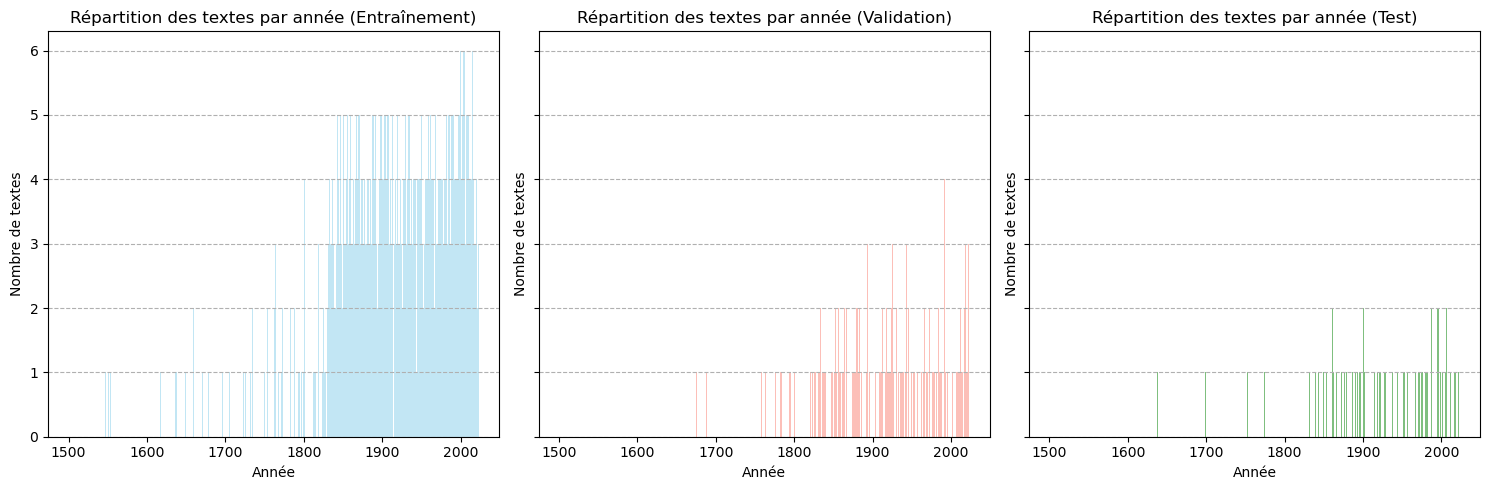

In [4]:
# Calculer la plage maximale des valeurs Y sur les trois ensembles de données
max_y = max(max(y_train), max(y_val), max(y_test))
min_y = min(min(y_train), min(y_val), min(y_test))

# Créer des sous-graphiques avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Tracer l'histogramme pour les données d'entraînement
axs[0].hist(y_train, bins=range(min_y, max_y + 1), alpha=0.5, color='skyblue')
axs[0].grid(axis='y', linestyle='--')
axs[0].set_xlabel('Année')
axs[0].set_ylabel('Nombre de textes')
axs[0].set_title('Répartition des textes par année (Entraînement)')

# Tracer l'histogramme pour les données de validation
axs[1].hist(y_val, bins=range(min_y, max_y + 1), alpha=0.5, color='salmon')
axs[1].grid(axis='y', linestyle='--')
axs[1].set_xlabel('Année')
axs[1].set_ylabel('Nombre de textes')
axs[1].set_title('Répartition des textes par année (Validation)')

# Tracer l'histogramme pour les données de test
axs[2].hist(y_test, bins=range(min_y, max_y + 1), alpha=0.5, color='green')
axs[2].grid(axis='y', linestyle='--')
axs[2].set_xlabel('Année')
axs[2].set_ylabel('Nombre de textes')
axs[2].set_title('Répartition des textes par année (Test)')

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()


## Tokenization + Embedding + division en sequence

In [5]:
# Longueur maximale des séquences
max_len = 10000
# Le nombre de caracteristique en plus de la taille d'embedding
# 3 éléments: le token unique + la frequence locale + la fréquence globale
word_param_number = 3

In [6]:
embedding_dim = 10

### Embedding

In [7]:
# #Pout télécharger le model
# fasttext.util.download_model('fr', if_exists='ignore')

In [8]:
# # Récupérer le model
# ft = fasttext.load_model('cc.fr.300.bin')

In [9]:
# # Changer la taille du model (on passe à un embedding de dimension 25)
# fasttext.util.reduce_model(ft, embedding_dim)

In [10]:
# # Récupération de la matrice contenant les embedding de chaque mot
# input_matrix = ft.get_input_matrix()

### Classe Fonction et Variable

In [11]:
class WordTokenizer:
    def __init__(self, dict_word=None, dict_word_frequence=None):
        if dict_word is None:
            self.dict_word = {}
            self.word_freq = {}
            self.index = 1
        else:
            self.dict_word = dict_word
            self.index = len(dict_word) + 1
            self.word_freq = dict_word_frequence

    def fit(self, list_of_texts):
        # Si dict_word_frequence est None, initialiser word_freq
        if self.word_freq is None:
            self.word_freq = {}

        # Calculer la fréquence des mots
        for text in list_of_texts:
            tokens = word_tokenize(text)
            for token in tokens:
                if token in self.word_freq:
                    self.word_freq[token] += 1
                else:
                    self.word_freq[token] = 1

        # Trier les mots par fréquence dans l'ordre décroissant
        sorted_words = sorted(self.word_freq.items(), key=lambda x: x[1], reverse=True)

        # Attribuer des indices en fonction de la fréquence
        for _, (word, _) in enumerate(sorted_words):
            if word not in self.dict_word:
                self.dict_word[word] = self.index
                self.index += 1

        print("\nTokenization complete.")

    def get_local_word_freq(self, tokens):
        # Initialise un dictionnaire pour stocker la fréquence locale des mots
        local_word_freq = {}
        # Parcourt tous les tokens dans la liste
        for token in tokens:
            # Vérifie si le token n'est pas déjà présent dans le dictionnaire
            if token not in local_word_freq:
                # Si le token n'est pas présent, initialise sa fréquence à 1
                local_word_freq[token] = 1
            else:
                # Si le token est déjà présent, incrémente sa fréquence de 1
                local_word_freq[token] += 1
        # Retourne le dictionnaire de fréquence locale des mots
        return local_word_freq

    def get_local_word_freq(self, tokens):
        # Initialise un dictionnaire pour stocker la fréquence locale des mots
        local_word_freq = {}
        # Parcourt tous les tokens dans la liste
        for token in tokens:
            # Vérifie si le token n'est pas déjà présent dans le dictionnaire
            if token not in local_word_freq:
                # Si le token n'est pas présent, initialise sa fréquence à 1
                local_word_freq[token] = 1
            else:
                # Si le token est déjà présent, incrémente sa fréquence de 1
                local_word_freq[token] += 1
        # Retourne le dictionnaire de fréquence locale des mots
        return local_word_freq

    def tokenize(self, list_of_texts):
        total_texts = len(list_of_texts)
        # Initialise un tableau pour stocker les tokens de chaque texte
        token_arrays = np.empty((total_texts,), dtype=object)
        local_occs = np.empty((total_texts,), dtype=object)
        token_pos = np.empty((total_texts,), dtype=object)
        # Parcourt chaque texte dans la liste
        for i, text in enumerate(list_of_texts):
            # Tokenise le texte en mots individuels
            tokens = word_tokenize(text)

            # Initialise un tableau pour stocker les informations sur chaque token
            token_array = np.empty((len(tokens), ), dtype=np.float32)
            local_occ = np.empty((len(tokens), ), dtype=np.float32)
            token_pos_arr = np.empty((len(tokens), ), dtype=np.float32)
            # Calcule la fréquence locale des mots dans le texte
            local_word_freq = self.get_local_word_freq(tokens)

            position = 1
            # Parcourt chaque token dans le texte
            for j, token in enumerate(tokens):
                # Position du token
                if token == '.':
                    position = 0
                token_pos_arr[j] = position
                #print("token :",token," pos :",position)
                position +=1

                # Vérifie si le token n'est pas dans le dictionnaire des mots
                if token not in self.dict_word:
                    token_array[j] = 0
                    local_occ[j] = local_word_freq[token]
                else:
                    token_array[j] = self.dict_word[token]
                    local_occ[j] = local_word_freq[token]
            
            token_arrays[i] = token_array
            local_occs[i] = local_occ
            token_pos[i] = token_pos_arr
            
            percentage = (i + 1) / total_texts * 100
            print(f"Progression : {percentage:.2f}% complète")

        print("\nTokenisation terminée.")
        return token_arrays,local_occs, token_pos

In [12]:
from math import ceil

def diviser_liste(liste,labels, taille):
    resultats = []
    res_labels = []
    nb_sequence_per_book = []
    ind = 0
    # Parcours de chaque sous-liste dans la liste principale
    for sous_liste in liste:
        longueur = len(sous_liste)
        if(longueur<taille):
            ind+=1
            continue
        nbtour = ceil(longueur / taille)
        lastpos=0
        # Division de la sous-liste en morceaux de taille spécifiée
        nb_sequence = 0
        for i in range(nbtour):
            if(lastpos + taille > longueur):
              if((lastpos + taille)-longueur > taille/2):
                  break
              lastpos -= (lastpos + taille)-longueur

            # Ajout du morceau à la liste de résultats
            resultat = sous_liste[lastpos:lastpos + taille]
            lastpos = lastpos + taille
            resultats.append(resultat)

            # A chaque fois que je divisie, jajoute le label au meme indice
            res_labels.append(labels[ind])
            nb_sequence += 1
        ind+=1
        nb_sequence_per_book.append(nb_sequence)

    # Convertir resultats et res_labels en tableaux numpy
    resultats = np.array(resultats)
    res_labels = np.array(res_labels)

    return resultats,res_labels,nb_sequence_per_book

def diviser_liste2(liste,taille):
    resultats = []
    ind = 0
    # Parcours de chaque sous-liste dans la liste principale
    for sous_liste in liste:
        longueur = len(sous_liste)
        if(longueur<taille):
            ind+=1
            continue
        nbtour = ceil(longueur / taille)
        lastpos=0
        # Division de la sous-liste en morceaux de taille spécifiée
        for i in range(nbtour):
            if(lastpos + taille > longueur):
              if((lastpos + taille)-longueur > taille/2):
                  break
              lastpos -= (lastpos + taille)-longueur

            # Ajout du morceau à la liste de résultats
            resultat = sous_liste[lastpos:lastpos + taille]
            lastpos = lastpos + taille
            resultats.append(resultat)
        ind+=1

    # Convertir resultats et res_labels en tableaux numpy
    resultats = np.array(resultats)

    return resultats

### Création du tokenizer + sauvegarde du dictionnaire

In [13]:
# tokenizer = WordTokenizer()
# tokenizer.fit(X_train)
# tokenizer.fit(X_val)

In [14]:
# import json

# # Chemin du fichier de sauvegarde
# path_dict_word = "dict_word.json"
# path_dict_word_freq = "dict_word_freq.json"

# # Sauvegarde du dictionnaire en JSON dans un fichier
# with open(path_dict_word, "w") as json_file:
#     json.dump(tokenizer.dict_word, json_file)
# with open(path_dict_word_freq, "w") as json_file:
#     json.dump(tokenizer.word_freq, json_file)

### Récupération dico + Création du tokenizer 

In [15]:
import json

# Chemin du fichier JSON à lire
path_dict_word = "dict_word.json"
path_dict_word_freq = "dict_word_freq.json"

ditc_word = {}
word_freq = {}

# Lecture du fichier JSON
with open(path_dict_word, "r") as json_file:
    ditc_word = json.load(json_file)
with open(path_dict_word_freq, "r") as json_file:
    word_freq = json.load(json_file)
tokenizer = WordTokenizer(dict_word=ditc_word,dict_word_frequence=word_freq)

token_number = tokenizer.index

In [16]:
# Afficher les 100 premiers éléments
first_100 = {word: tokenizer.dict_word[word] for word in list(tokenizer.dict_word.keys())[:100]}
print(first_100)

{',': 1, '.': 2, 'de': 3, 'la': 4, 'et': 5, 'le': 6, 'à': 7, 'il': 8, 'l': 9, 'les': 10, 'un': 11, 'que': 12, 'd': 13, 'en': 14, 'je': 15, 'une': 16, 'elle': 17, 'des': 18, 'qui': 19, 'pas': 20, 'est': 21, 'qu': 22, 'ne': 23, 'dans': 24, '!': 25, 'se': 26, 'ce': 27, 'vous': 28, 'pour': 29, 'du': 30, 'n': 31, 's': 32, '?': 33, 'son': 34, 'était': 35, 'au': 36, 'lui': 37, 'plus': 38, 'avait': 39, 'mais': 40, ';': 41, 'a': 42, 'sur': 43, 'on': 44, ':': 45, 'c': 46, 'sa': 47, 'avec': 48, 'par': 49, 'nous': 50, 'j': 51, 'tout': 52, 'me': 53, 'comme': 54, 'ses': 55, 'si': 56, 'bien': 57, 'm': 58, 'y': 59, 'cette': 60, 'tu': 61, 'dit': 62, 'ils': 63, 'mon': 64, 'ai': 65, 'même': 66, 'sans': 67, 'moi': 68, 'être': 69, 'où': 70, 'ou': 71, 'fait': 72, 'deux': 73, 'aux': 74, 'là': 75, 'ces': 76, 'ma': 77, 'faire': 78, 'leur': 79, 't': 80, 'encore': 81, 'quand': 82, 'rien': 83, 'peu': 84, 'aussi': 85, 'tous': 86, 'autre': 87, 'homme': 88, 'ça': 89, 'peut': 90, 'sont': 91, 'temps': 92, 'non': 93, '

### Training Data

In [17]:
# Transformation de chaque texte dans X_train en séquence
sequences_trainA,sequences_trainB,sequences_trainC = tokenizer.tokenize(X_train)

Progression : 0.12% complète
Progression : 0.24% complète
Progression : 0.37% complète
Progression : 0.49% complète
Progression : 0.61% complète
Progression : 0.73% complète
Progression : 0.85% complète
Progression : 0.98% complète
Progression : 1.10% complète
Progression : 1.22% complète
Progression : 1.34% complète
Progression : 1.46% complète
Progression : 1.59% complète
Progression : 1.71% complète
Progression : 1.83% complète
Progression : 1.95% complète


KeyboardInterrupt: 

In [ ]:
# Division des données en séquences de longueur maximale max_len
data_trainA,y_train,sequence_count_book_train = diviser_liste(sequences_trainA,y_train, max_len)
data_trainB = diviser_liste2(sequences_trainB, max_len)
data_trainC = diviser_liste2(sequences_trainC, max_len)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_trainA))

Nombre de séquences de données: 6085


#### Save & Load

In [ ]:
# np.save("Data/tokenized_train",np.array(sequences_train))

In [ ]:
# sequences_train = np.load("Data/tokenized_train.npy", allow_pickle=True)

In [ ]:
# np.save("Data/data_split_train",data_train)
# np.save("Data/y_split_train",y_train)

In [ ]:
# data_train = np.load("Data/data_split_train.npy", allow_pickle=True)
# y_train = np.load("Data/y_split_train.npy", allow_pickle=True)

### Validation Data

In [ ]:
sequences_valA,sequences_valB,sequences_valC = tokenizer.tokenize(X_val)

Progression : 0.61% complète
Progression : 1.23% complète
Progression : 1.84% complète
Progression : 2.45% complète
Progression : 3.07% complète
Progression : 3.68% complète
Progression : 4.29% complète
Progression : 4.91% complète
Progression : 5.52% complète
Progression : 6.13% complète
Progression : 6.75% complète
Progression : 7.36% complète
Progression : 7.98% complète
Progression : 8.59% complète
Progression : 9.20% complète
Progression : 9.82% complète
Progression : 10.43% complète
Progression : 11.04% complète
Progression : 11.66% complète
Progression : 12.27% complète
Progression : 12.88% complète
Progression : 13.50% complète
Progression : 14.11% complète
Progression : 14.72% complète
Progression : 15.34% complète
Progression : 15.95% complète
Progression : 16.56% complète
Progression : 17.18% complète
Progression : 17.79% complète
Progression : 18.40% complète
Progression : 19.02% complète
Progression : 19.63% complète
Progression : 20.25% complète
Progression : 20.86% compl

In [ ]:
# Division des données en séquences de longueur maximale max_len
data_valA,y_val,sequence_count_book_val = diviser_liste(sequences_valA,y_val, max_len)
data_valB = diviser_liste2(sequences_valB, max_len)
data_valC =diviser_liste2(sequences_valC, max_len)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_valA))

Nombre de séquences de données: 1260


#### Save & Load

In [ ]:
# np.save("Data/tokenized_val",np.array(sequences_val))

In [26]:
# sequences_val = np.load("Data/tokenized_val.npy", allow_pickle=True)

In [27]:
# np.save("Data/data_split_val",data_val)
# np.save("Data/y_split_val",y_val)

In [28]:
# data_val = np.load("Data/data_split_val.npy", allow_pickle=True)
# y_val = np.load("Data/y_split_val.npy", allow_pickle=True)

### Test Data

In [29]:
# Transformation de chaque texte dans X_test en une séquence d'entiers
sequences_testA,sequences_testB,sequences_testC = tokenizer.tokenize(X_test)

Progression : 1.45% complète
Progression : 2.90% complète
Progression : 4.35% complète
Progression : 5.80% complète
Progression : 7.25% complète
Progression : 8.70% complète
Progression : 10.14% complète
Progression : 11.59% complète
Progression : 13.04% complète
Progression : 14.49% complète
Progression : 15.94% complète
Progression : 17.39% complète
Progression : 18.84% complète
Progression : 20.29% complète
Progression : 21.74% complète
Progression : 23.19% complète
Progression : 24.64% complète
Progression : 26.09% complète
Progression : 27.54% complète
Progression : 28.99% complète
Progression : 30.43% complète
Progression : 31.88% complète
Progression : 33.33% complète
Progression : 34.78% complète
Progression : 36.23% complète
Progression : 37.68% complète
Progression : 39.13% complète
Progression : 40.58% complète
Progression : 42.03% complète
Progression : 43.48% complète
Progression : 44.93% complète
Progression : 46.38% complète
Progression : 47.83% complète
Progression : 49

In [121]:
# Division des données en séquences de longueur maximale max_len
data_testA,y_test,sequence_count_book_test = diviser_liste(sequences_testA,y_test, max_len)
data_testB = diviser_liste2(sequences_testB, max_len)
data_testC = diviser_liste2(sequences_testC, max_len)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_testA))

Nombre de séquences de données: 533


#### Save & Load

In [31]:
# np.save("Data/tokenized_test",np.array(sequences_test))

In [32]:
# sequences_test = np.load("Data/tokenized_test.npy", allow_pickle=True)

In [33]:
# np.save("Data/data_split_test",data_test)
# np.save("Data/y_split_test",y_test)

In [34]:
# data_test = np.load("Data/data_split_test.npy", allow_pickle=True)
# y_test = np.load("Data/y_split_test.npy", allow_pickle=True)

### Affichage informations

In [35]:
print("Nombre de séquences de données (Training):", len(data_trainA))
print("Nombre de séquences de données (Validation):", len(data_valA))
print("Nombre de séquences de données (Test):", len(data_testA))

Nombre de séquences de données (Training): 1971
Nombre de séquences de données (Validation): 413
Nombre de séquences de données (Test): 166


# Définition des architectures des modeles testés

In [216]:
def define_multi_model(max_len, vocab_size):

    inputA = Input(shape=(max_len,), name='input_tokens')  # Entrée pour les mots tokenisés
    inputB = Input(shape=(max_len,), name='input_word_freq')  # Entrée pour les fréquences des mots dans le texte
    inputC = Input(shape=(max_len,), name='input_word_pos')  # Entrée pour la position des mots

    # Branche A
    # Couche pour l'entrée des mots tokenisés
    x1 = Embedding(input_dim=vocab_size, output_dim=40, input_length=max_len, name='embedding_tokens_A')(inputA)
    for i in range(3):
        x1 = Conv1D(filters=32, kernel_size=21, activation='relu', name='conv1d_A_'+str(i))(x1)
        x1 = MaxPooling1D(pool_size=2, name='maxpooling_A_'+str(i))(x1)
    x1 = Flatten(name='flatten_A')(x1)
    x1 = Dropout(0.4, name='dropout_A')(x1)
    x1 = Dense(32, activation="relu", name='dense_A')(x1)

    x2 = Embedding(input_dim=vocab_size, output_dim=40, input_length=max_len, name='embedding_tokens_A2')(inputA)
    for i in range(3):
        x2 = Conv1D(filters=32, kernel_size=3, activation='relu', name='conv1d_A2_'+str(i))(x2)
        x2 = MaxPooling1D(pool_size=2, name='maxpooling_A2_'+str(i))(x2)
    x2 = Flatten(name='flatten_A2')(x2)
    x2 = Dropout(0.4, name='dropout_A2')(x2)
    x2 = Dense(32, activation="relu", name='dense_A2')(x2)


    # Branche B
    # Couches pour l'entrée des fréquences de mots
    y1 = Embedding(input_dim=vocab_size, output_dim=40, input_length=max_len, name='embedding_tokens_B')(inputB)
    for i in range(3):
        y1 = Conv1D(filters=32, kernel_size=21, activation='relu', name='conv1d_B_'+str(i))(y1)
        y1 = MaxPooling1D(pool_size=2, name='maxpooling_B_'+str(i))(y1)
    y1 = Flatten(name='flatten_B')(y1)
    y1 = Dropout(0.4, name='dropout_B')(y1)
    y1 = Dense(32, activation="relu", name='dense_B')(y1)

    # Branche C
    # Couches pour l'entrée de la position des mots
    y2 = Embedding(input_dim=vocab_size, output_dim=40, input_length=max_len, name='embedding_tokens_C')(inputC)
    for i in range(3):
        y2 = Conv1D(filters=32, kernel_size=21, activation='relu', name='conv1d_C_'+str(i))(y2)
        y2 = MaxPooling1D(pool_size=2, name='maxpooling_C_'+str(i))(y2)
    y2 = Flatten(name='flatten_C')(y2)
    y2 = Dropout(0.4, name='dropout_C')(y2)
    y2 = Dense(32, activation="relu", name='dense_C')(y2)
    
    # Concaténer les sorties de toutes les branches
    combined = concatenate([x1,x2, y2], name='concatenated_features')

    # Couches denses pour les sorties combinées
    z = Dense(64, activation="relu", name='dense_combined')(combined)
    z = Dense(1, activation="linear", name='output')(z)

    # Combinez les entrées et les sorties en un modèle
    model = Model(inputs=[inputA, inputB, inputC], outputs=z)
    
    return model

# def archi(model_params,input_shape):
#     # Pile linéaire de couches. 
#     # Dans ce modèle, les données passent à travers les couches dans l'ordre où elles ont été ajoutées.
#     model = Sequential()
    
#     model.add(Input(shape=input_shape))

#     model.add(Embedding(input_dim=token_number, output_dim=model_params['embedding_dim']))

#     model.add(Reshape(target_shape=(max_len, model_params['embedding_dim'] * input_shape[1])))

#     for i in range(model_params['count_conv1D']):
#         # Couche de convolution à une dimension (1D) au modèle.
#         model.add(Conv1D(filters=model_params['conv1D_1_filters'], kernel_size=model_params['conv1D_1_kernel'], activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))

#         if(model_params['pool_size'] != 0):
#             # Réduction de dimension par l'opération de pooling.
#             model.add(MaxPooling1D(pool_size=model_params['pool_size']))

#     if(model_params['dense_units'] != 0):
#         # Couche dense de neurones avec activation ReLU et régularisation L2.
#         model.add(Dense(units=model_params['dense_units'],kernel_regularizer=regularizers.l2(l=0.001)))

#     if(model_params['dropout'] != 0):
#         # Dropout pour éviter le surapprentissage.
#         model.add(Dropout(rate=model_params['dropout']))

#     # Transformation des données en un format adapté à une couche Dense.
#     model.add(Flatten())

#     # Couche de sortie avec une seule sortie.
#     model.add(Dense(units=1))

#     return model

# La fonction ReLU est couramment utilisée dans les réseaux de neurones en raison de sa simplicité et de sa capacité à introduire une non-linéarité dans le modèle,
# ce qui permet au réseau de capturer des motifs complexes dans les données.

# Entrainement des models

## Ou en entrainer un seul

### Un seul

In [217]:
from keras import backend as K

# Définition de la métrique personnalisée d'accuracy avec une tolérance de 20
def accuracy_with_tolerance(tolerance=20):
    def metric(y_true, y_pred):
        # Calcul de la différence absolue entre la valeur prédite et la valeur réelle
        diff = K.abs(y_pred - y_true)

        # Compte le nombre de prédictions qui sont dans la tolérance
        within_tolerance = K.less_equal(diff, tolerance)

        # Retourne le pourcentage de prédictions correctes
        return K.mean(K.cast(within_tolerance, 'float32'))

    return metric

In [218]:
from keras.utils.vis_utils import plot_model

utils.set_random_seed(420)

model_params = {'embedding_dim': 15,
                'count_conv1D':1,
                'conv1D_1_filters': 64,
                'conv1D_1_kernel': 9,
                'pool_size':2,
                'dense_units': 32,
                'dropout':0.4 }

# Création du modèle en utilisant l'architecture spécifiée
# input_shape = (max_len, embedding_dim+word_param_number)
#model = archi(model_params,input_shape)
model = define_multi_model(max_len, token_number)

plot_model(model, show_shapes=True, to_file='multichannel.png')

# Compilation du modèle avec l'optimiseur Adam, la fonction de perte 'mse' et la métrique 'mae'
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae',accuracy_with_tolerance(20)])
# Affichage de la structure du modèle
model.summary()

# Création du callback EarlyStopping pour surveiller la perte d'entraînement
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Création du callback EarlyStopping pour surveiller la perte de validation
early_stopping_val = EarlyStopping(monitor='val_loss', patience=3)

train = [data_trainA,data_trainB,data_trainC]
val = [data_valA,data_valB,data_valC]
test = [data_testA,data_testB,data_testC]

# with tf.device('/cpu:0'):
#    data_train_tensor = tf.convert_to_tensor(data_train, np.float32)
#    y_train_tensor = tf.convert_to_tensor(y_train, np.float32)
#    data_val_tensor = tf.convert_to_tensor(data_val, np.float32)
#    y_val_tensor = tf.convert_to_tensor(y_val, np.float32)
#    data_test_tensor = tf.convert_to_tensor(data_test, np.float32)
#    y_test_tensor = tf.convert_to_tensor(y_test, np.float32)

# Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
history = model.fit(train, y_train, epochs=1000, batch_size=64, validation_data=(val, y_val), callbacks=[early_stopping, early_stopping_val])

# L'historique de l'entraînement
history.history

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tokens (InputLayer)      [(None, 10000)]      0           []                               
                                                                                                  
 input_word_pos (InputLayer)    [(None, 10000)]      0           []                               
                                                                                                  
 embedding_tokens_A (Embedding)  (None, 10000, 40)   11655600    ['input_tokens[0][0]']           
                                                                                                  
 embedding_tokens_A2 (Embedding  (None, 10000, 40)   11655600    ['input_tokens[0][0]']           
 )                                                                                         

{'loss': [381084.53125,
  2443.591064453125,
  930.1953735351562,
  458.7742004394531,
  262.9754943847656,
  192.91419982910156,
  136.44900512695312,
  119.55428314208984,
  107.2603759765625,
  135.6184844970703,
  163.38949584960938],
 'mae': [338.4974365234375,
  35.727638244628906,
  20.707794189453125,
  14.482983589172363,
  11.380741119384766,
  9.27787971496582,
  8.186481475830078,
  8.018945693969727,
  7.490655899047852,
  7.464077472686768,
  8.281026840209961],
 'metric': [0.12249348312616348,
  0.37838542461395264,
  0.6227864623069763,
  0.7708659172058105,
  0.8603515625,
  0.9191080927848816,
  0.9488932490348816,
  0.9529948234558105,
  0.9601237177848816,
  0.9645182490348816,
  0.9466145634651184],
 'val_loss': [3437.873779296875,
  1828.8170166015625,
  1077.2698974609375,
  930.3927612304688,
  925.3255004882812,
  859.078857421875,
  843.2025756835938,
  819.84033203125,
  840.9642944335938,
  1188.46337890625,
  976.5712280273438],
 'val_mae': [46.657432556152

# Evaluation du model

## Evaluation par séquence

In [211]:
# Évaluer le modèle sur les données de test
print("Évaluation sur les données de test :")
perte_test, mae_test,accuracy_test = model.evaluate(test, y_test)
print()

# Évaluer le modèle sur les données d'entraînement
print("Évaluation sur les données d'entraînement :")
perte_entrainement, mae_entrainement,accuracy_entrainement = model.evaluate(train, y_train)
print()

# Évaluer le modèle sur les données de validation
print("Évaluation sur les données de validation :")
perte_validation, mae_validation,accuracy_validation = model.evaluate(val, y_val)
print()

Évaluation sur les données de test :
17/17 [==============================] - 3s 154ms/step - loss: 968.1437 - mae: 23.2527 - metric: 0.5170

Évaluation sur les données d'entraînement :
191/191 [==============================] - 23s 122ms/step - loss: 102.5547 - mae: 8.1279 - metric: 0.9720

Évaluation sur les données de validation :
40/40 [==============================] - 5s 120ms/step - loss: 918.7557 - mae: 22.7627 - metric: 0.5492



In [212]:
# Prédiction des dates
y_pred = model.predict(test)

error_samples = []  # Liste pour stocker les échantillons en dehors de la tolérance
tolerance = 20  # Tolérance définie pour considérer les prédictions comme correctes
within_tolerance_count = 0  # Compteur pour les prédictions dans la tolérance

# Parcours de chaque échantillon dans les données de test
for i in range(len(y_test)):
    # Vérification si la différence entre la valeur prédite et la valeur réelle est dans la tolérance
    if abs(round(y_pred[i][0]) - y_test[i]) <= tolerance:
        within_tolerance_count += 1

# Calcul de l'exactitude dans la tolérance
accuracy_within_tolerance = (within_tolerance_count / len(y_test)) * 100

print("Accuracy within tolerance:", accuracy_within_tolerance, "%")

17/17 [==============================] - 2s 136ms/step
Accuracy within tolerance: 53.283302063789876 %


## Evaluation par livre

In [213]:
import statistics

# Prédiction des dates
y_pred = model.predict(test)  
y_pred = y_pred.flatten()  

current = 0
diff_total = 0

predicted_book_date = np.zeros(len(sequence_count_book_test)) # Liste pour stocker les dates de prédites pour chaque livre
true_book_date = np.zeros(len(sequence_count_book_test))  # Liste pour stocker les dates réelles

ind = 0

for nb in sequence_count_book_test: 
    dates = []  # Liste pour stocker les dates prédites pour chaque séquence
    # Parcours de séquence
    for i in range(nb):
        dates.append(y_pred[current])  # Ajouter la prédiction actuelle à la liste des dates
        current += 1  # Incrémenter l'indice pour obtenir la prochaine prédiction

    # Calculer la moyenne des dates prédites dans cette séquence
    # date = sum(dates) / len(dates)
    date = statistics.median(dates)
    predicted_book_date[ind] = date
    true_book_date[ind] = y_test[current-1]
    # Calculer la différence absolue entre la moyenne prédite et la vérité terrain
    diff = abs(date - y_test[current-1])
    diff_total += diff

    ind += 1

# Calculer la MAE pour les livres
mae_book = diff_total / len(sequence_count_book_test)

print("Evaluation on Test Data, MAE (Mean Absolute Error):", mae_book)


# Prédiction des dates
y_pred = model.predict(test)

error_samples = []  # Liste pour stocker les échantillons en dehors de la tolérance
tolerance = 20  # Tolérance définie pour considérer les prédictions comme correctes
within_tolerance_count = 0  # Compteur pour les prédictions dans la tolérance

for i in range(len(predicted_book_date)):
    # Vérification si la différence entre la date réelle et la date prédite est dans la tolérance
    if abs(round(true_book_date[i]) - predicted_book_date[i]) <= tolerance:
        within_tolerance_count += 1

# Calcul de l'exactitude dans la tolérance
accuracy_within_tolerance = (within_tolerance_count / len(predicted_book_date)) * 100

print("Accuracy within tolerance:", accuracy_within_tolerance, "%")

17/17 [==============================] - 4s 224ms/step
Evaluation on Test Data, MAE (Mean Absolute Error): 24.950944131879663
17/17 [==============================] - 3s 169ms/step
Accuracy within tolerance: 55.223880597014926 %


# Save in Datas

## Create file

In [47]:
# df_models = pd.DataFrame()

# df_models['Model Name'] = ["Model 1"]
# df_models['MAE'] = [mae_test]
# df_models['MSE'] = [loss_test]
# df_models['Accuracy with tolerance 15 (%)'] = [accuracy_within_tolerance]
# # df_models['Train_MAE'] = [mae_train]
# # df_models['Train_MSE'] = [loss_train]
# # df_models['Val_MAE'] = [mae_validation]
# # df_models['Val_MSE'] = [loss_validation]

# # Add columns for each element in model_params
# for key, value in model_params.items():
#     df_models[key] = value

# df_models.to_csv('df_models.csv', index=False)

# # Afficher les données
# display(df_models)

## Add data

In [48]:
# # Pour supprimer une mauvaise ligne
# # Charger les données à partir du fichier CSV
# df_models = pd.read_csv('df_models.csv')
# df_models.drop(len(df_models)-1, inplace=True)
# display(df_models)
# df_models.to_csv('df_models.csv', index=False)

In [ ]:
# Charger les données à partir du fichier CSV
df_models = pd.read_csv('df_models.csv')
model_name = "Model "+str(len(df_models)+1)
nouvelle_ligne = [model_name,
                  mae_test,
                  loss_test,
                  accuracy_within_tolerance,
                  model_params['embedding_dim'],
                  model_params['conv1D_1_filters'],
                  model_params['conv1D_1_kernel'],
                  model_params['pool_size'],
                  model_params['dense_units'],
                  model_params['dropout']]

# Ajouter la nouvelle ligne à la DataFrame
df_models.loc[len(df_models)] = nouvelle_ligne

df_models.to_csv('df_models.csv', index=False)

# Afficher les données mises à jour
display(df_models)

# Predictions

In [214]:
# Utiliser le modèle pour prédire les dates sur les données de test
predictions = model.predict(test)

# Afficher les dates prédites
print("Dates prédites :")
for prediction in predictions:
    print(prediction)

print("max: ",max(predictions))
print("min: ",min(predictions))

17/17 [==============================] - 2s 133ms/step
Dates prédites :
[1976.2003]
[1985.2179]
[1976.247]
[1977.8011]
[1982.0353]
[1984.8822]
[1990.8021]
[1970.4888]
[2002.7533]
[1988.9814]
[2005.4554]
[1979.0804]
[1980.9313]
[1982.4136]
[1981.2598]
[1982.7142]
[2005.3187]
[2016.9235]
[1977.1256]
[1839.6941]
[1848.9401]
[1862.4363]
[1869.5242]
[1885.649]
[1874.5784]
[1884.4537]
[1874.6908]
[1880.9434]
[1890.3478]
[1880.8055]
[1877.4913]
[1879.0177]
[1845.4084]
[1855.4023]
[1852.5543]
[1869.0062]
[1864.5431]
[1858.3778]
[1879.5559]
[1864.6517]
[1829.17]
[1851.4257]
[1877.7748]
[1839.5189]
[1852.2775]
[1852.3849]
[1865.7766]
[1856.7062]
[1853.7361]
[1855.8247]
[1864.1588]
[1848.7548]
[1857.7675]
[1903.5415]
[1897.0153]
[1885.2983]
[1890.0109]
[1907.7389]
[1915.5883]
[1903.3075]
[1918.2777]
[1907.2051]
[1915.966]
[1907.7354]
[1913.5925]
[1965.8488]
[1969.3458]
[1984.8722]
[1986.482]
[1994.0917]
[1971.5693]
[1994.6912]
[1989.285]
[1989.336]
[1931.0361]
[1930.788]
[1931.3083]
[1913.4268]
[

# Graphes

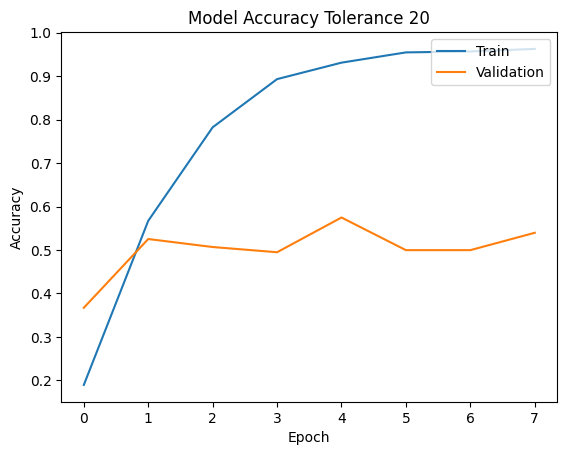

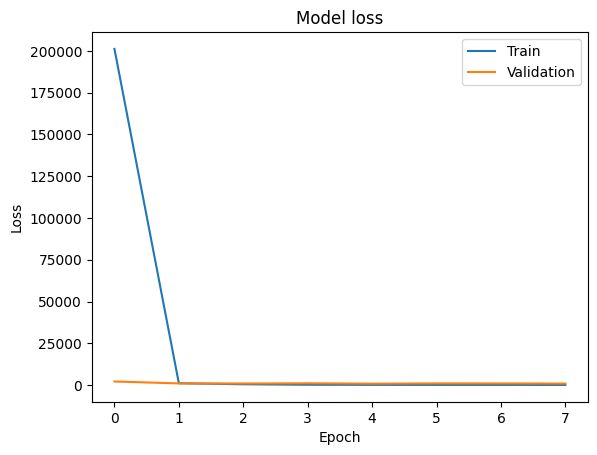

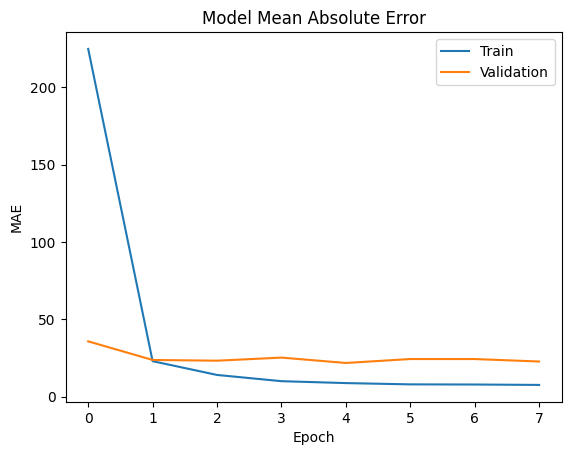

17/17 [==============================] - 3s 164ms/step


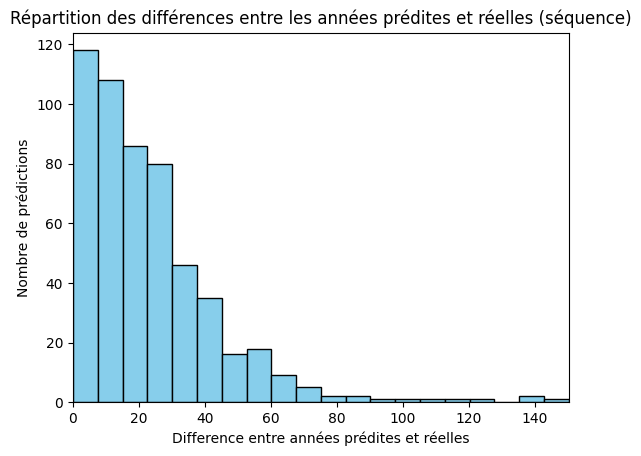

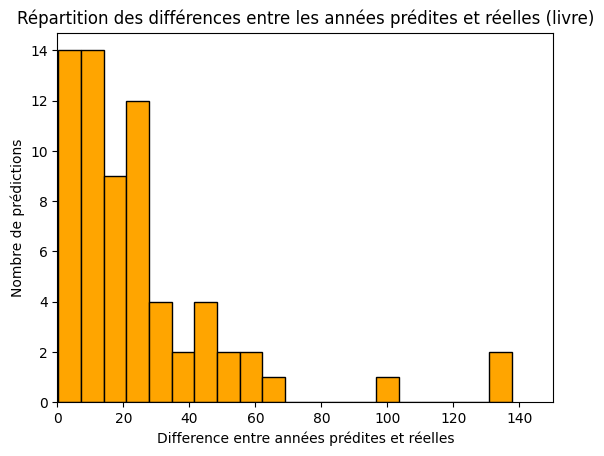

17/17 [==============================] - 2s 116ms/step
Accuracy avec exacte matching: 0.5628517823639775 %
Accuracy avec tolerance de 15 est: 43.71482176360225 %


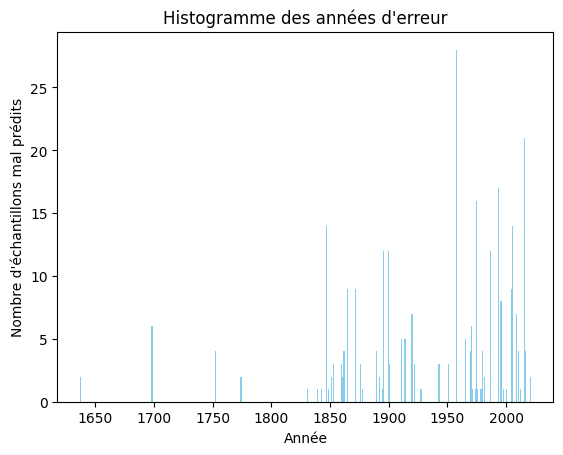

In [215]:
# Plot training & validation accuracy with tolerance 20
plt.plot(history.history['metric'][0:])
plt.plot(history.history['val_metric'][0:])
plt.title('Model Accuracy Tolerance 20')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][0:])
plt.plot(history.history['val_loss'][0:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#Plot MAE
plt.plot(history.history['mae'][0:]) 
plt.plot(history.history['val_mae'][0:]) 
plt.title('Model Mean Absolute Error') 
plt.ylabel('MAE') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

#Calcul de la différence entre les années prédites et les années réelles
y_pred = model.predict(test) 
diff = np.abs(y_test - y_pred.flatten())
diff2 = np.abs(predicted_book_date - true_book_date)

# Calcul des limites maximales des différences pour les deux jeux de données
max_diff = max(np.max(diff), np.max(diff2))

# Plot de l'histogramme des différences entre les années prédites et réelles pour la séquence
plt.hist(diff, bins=20, color='skyblue', edgecolor='black') 
plt.xlabel('Difference entre années prédites et réelles') 
plt.ylabel('Nombre de prédictions') 
plt.title('Répartition des différences entre les années prédites et réelles (séquence)') 
plt.xlim(0, max_diff)  # Limite des axes pour les deux graphiques
plt.show()

# Plot de l'histogramme des différences entre les années prédites et réelles pour le livre
plt.hist(diff2, bins=20, color='orange', edgecolor='black') 
plt.xlabel('Difference entre années prédites et réelles') 
plt.ylabel('Nombre de prédictions') 
plt.title('Répartition des différences entre les années prédites et réelles (livre)') 
plt.xlim(0, max_diff)  # Limite des axes pour les deux graphiques
plt.show()



#-----------------------------------voir quelle année est la plus dure----------------------------------#
y_pred = model.predict(test)
error_samples = []
exact_matches_count = 0

for i in range(len(y_test)):
    if round(y_pred[i][0]) != y_test[i]:
        error_samples.append(y_test[i])
    else:
        exact_matches_count += 1

accuracy_exact_matches = (exact_matches_count / len(y_test)) * 100

print("Accuracy avec exacte matching:", accuracy_exact_matches, "%")


#------------------------voir quelle année est la plus dure (tolerance de 15)---------------------------#
error_samples = []
tolerance = 15
within_tolerance_count = 0

for i in range(len(y_test)):
    if abs(round(y_pred[i][0]) - y_test[i]) > tolerance:
        error_samples.append(y_test[i])
    else:
        within_tolerance_count += 1

accuracy_within_tolerance = (within_tolerance_count / len(y_test)) * 100

print("Accuracy avec tolerance de", tolerance, "est:", accuracy_within_tolerance, "%")


# Créer un histogramme des années d'erreur
plt.hist(error_samples, bins=max(y_test)-min(y_test)+1, color='skyblue')
plt.xlabel('Année')
plt.ylabel('Nombre d\'échantillons mal prédits')
plt.title('Histogramme des années d\'erreur')
plt.show()

# Load & Save Model

In [43]:
# #Sauvegarder le modèle complet au format HDF5
# model.save('model/20_04/model_to_show_3.h5')

In [73]:
# # Charger le modèle complet
# from keras.models import load_model
# model = load_model('model/model_to_show_2.h5')

# model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tokens (InputLayer)      [(None, 30000)]      0           []                               
                                                                                                  
 input_word_pos (InputLayer)    [(None, 30000)]      0           []                               
                                                                                                  
 embedding_tokens_A1 (Embedding  (None, 30000, 40)   11655600    ['input_tokens[0][0]']           
 )                                                                                                
                                                                                                  
 embedding_tokens_C (Embedding)  (None, 30000, 40)   11655600    ['input_word_pos[0][0]']   